In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l



In [3]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项

    Defined in :numref:`sec_seq2seq_decoder`"""
    
    # [None, :] 将新增一个维度
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

#@save
def masked_softmax(X, valid_lens):
    """将X展成二维只保留vaLid_lens部分并执行softmax"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)    
    
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3])),masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))
    
    

(tensor([[[0.4484, 0.5516, 0.0000, 0.0000],
          [0.6396, 0.3604, 0.0000, 0.0000]],
 
         [[0.3300, 0.4533, 0.2167, 0.0000],
          [0.2178, 0.3837, 0.3985, 0.0000]]]),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.4760, 0.2093, 0.3148, 0.0000]],
 
         [[0.5184, 0.4816, 0.0000, 0.0000],
          [0.1986, 0.2691, 0.2776, 0.2547]]]))

In [4]:
class AdditiveAttention(nn.Module):
    def __init__(self,key_size,query_size,num_hiddens,dropout,**kwargs):
        super(AdditiveAttention,self).__init__(**kwargs)
        self.key_size = key_size
        self.query_size = query_size
        self.num_hiddens = num_hiddens
        self.dropout = nn.Dropout(dropout)
        self.W_q = nn.Linear(self.query_size, self.num_hiddens)
        self.W_k = nn.Linear(self.key_size, self.num_hiddens)
        self.W_v = nn.Linear(self.num_hiddens,1)
        
    def forward(self, q, k, v, valid_lens):
        """q.shape = (batch_size,查询个数,num_hiddens) ,keys和values类似（查询个数更换为键值对个数）"""
        q, k = self.W_q(q), self.W_k(k)
        """"由于query中每一条记录都需要和keys中的每一条记录相加实现查询，最终q+k的形状应该为(batch_size,查询个数,键值对个数,num_hiddens),所以在这里执行升维操作方便之后广播"""        
        q, k = q.unsqueeze(2), k.unsqueeze(1)
        """这里再次线性变换使得原先num_hiddens大小的输入映射为标量（实现降维）方便之后与values相乘"""
        scores = self.W_v(nn.functional.tanh(q+k)).squeeze(-1)
        self.attention_weight = masked_softmax(
            scores,
            valid_lens
        )
        return torch.bmm(self.dropout(self.attention_weight), v)
        


queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)
        
        

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

In [5]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, valid_lens):
        self.attention_weights = masked_softmax(
            torch.bmm(q, k.transpose(1, 2)) / math.sqrt(q.shape[-1]), valid_lens
        )
        return torch.bmm(self.dropout(self.attention_weights), v)
        
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

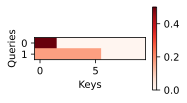

In [6]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [7]:
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.0340, -0.2268, -0.3174, -0.2540,  0.3098,  0.4298, -0.3935,  0.4555],
        [ 0.0340, -0.2268, -0.3174, -0.2540,  0.3098,  0.4298, -0.3935,  0.4555],
        [ 0.0340, -0.2268, -0.3174, -0.2540,  0.3098,  0.4298, -0.3935,  0.4555]],
       grad_fn=<SelectBackward0>)

In [8]:
class MultiHeadAttention(nn.Module):

    def __init__(self, query_size, key_size, num_hiddens, value_size,num_heads, dropout, bias=False, **kwargs) -> None:
        super(MultiHeadAttention,self).__init__(**kwargs)
        self.num_heads = num_heads
        self.num_hiddens = num_hiddens
        self.W_k = nn.Linear(key_size, num_hiddens,bias)
        self.W_q = nn.Linear(query_size, num_hiddens,bias)
        self.W_v = nn.Linear(value_size, num_hiddens,bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens,bias)
        self.dropout = nn.Dropout(dropout)
        self.attention = DotProductAttention(dropout=dropout)
        
    def forward(self, q, k, v, valid_lens):
        q,k,v = self.W_q(q), self.W_k(k), self.W_v(v)
        q,k,v = self.transpose_qkv(q),self.transpose_qkv(k),self.transpose_qkv(v)
        
        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        out = self.transpose_output(self.attention(q,k,v,valid_lens))
        return self.W_o(out)
        
        
            
        
    
    def transpose_qkv(self,x):
        """"输入X形状：（batch_size, 查询个数或者键值对个数, 隐藏层大小）"""
        shape = x.shape
        x = x.reshape(shape[0], shape[1], self.num_heads, -1)
        x = x.permute(0, 2, 1, 3)
        shape = x.shape
        """"输出X形状：（batch_size*num_heads, 键值对个数, 隐藏层大小/num_heads）"""
        return x.reshape(-1, shape[2], shape[3])
    
    def transpose_output(self, x):
        shape = x.shape
        x = x.reshape(shape[0]//self.num_heads, -1, shape[1], shape[2])
        x = x.permute(0, 2, 1, 3)
        shape = x.shape
        return x.reshape(shape[0], shape[1], -1)
        


num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()
        

MultiHeadAttention(
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [9]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

In [12]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape,dropout, **kwargs) -> None:
        super(AddNorm,self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape=normalized_shape)
        
    def forward(self, x, y):
        return self.ln(self.dropout(y)+x)

add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [18]:
#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape
        
        

torch.Size([2, 100, 24])

In [19]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))
            
            
    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X
            

encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape
        

torch.Size([2, 100, 24])

In [22]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values # TODO 这个i确定没问题吗
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state
    
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape  
        
        

torch.Size([2, 100, 24])

In [28]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

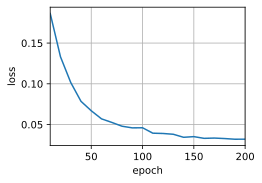

In [29]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [36]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000
